In [2]:
!pip install filterpy

     |████████████████████████████████| 184kB 929kB/s eta 0:00:01
  Stored in directory: /home/mike/.cache/pip/wheels/c3/0c/dd/e92392c3f38a41371602d99fc77d6c1d42aadbf0c6afccdd02
Successfully built filterpy


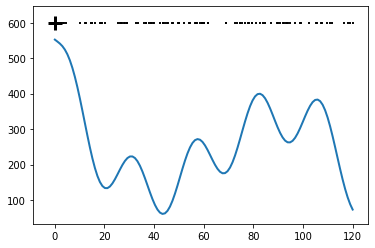

final position error, variance:
	 7.203165156861385 364.8928769160589


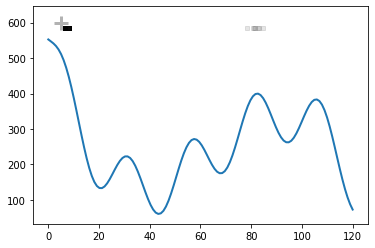

final position error, variance:
	 7.853790267920175 536.4805213969406


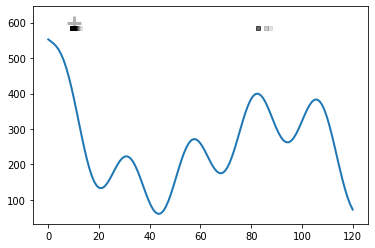

final position error, variance:
	 61.19270750529684 718.1707741186652


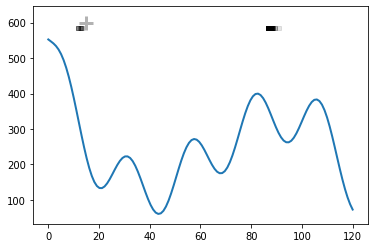

final position error, variance:
	 71.76378894892319 4.683816835890167


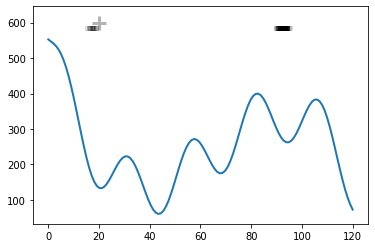

final position error, variance:
	 71.60505146859877 1.9786209613886494


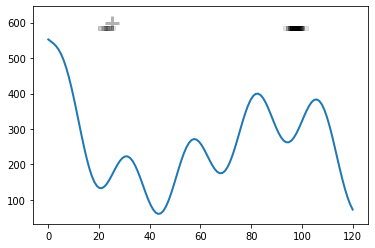

final position error, variance:
	 69.46813014921376 56.09449735642039


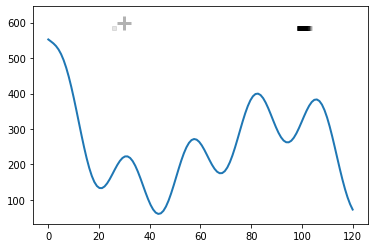

final position error, variance:
	 69.72143066203105 49.41426995729013


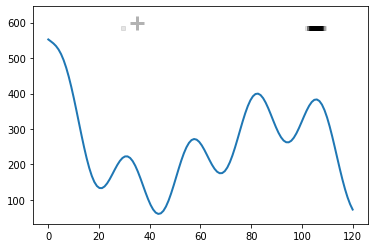

final position error, variance:
	 55.83035808782276 1093.8377850749453


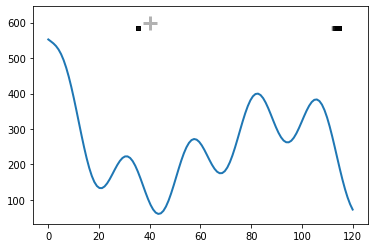

final position error, variance:
	 54.176805116643706 1196.9176055971843


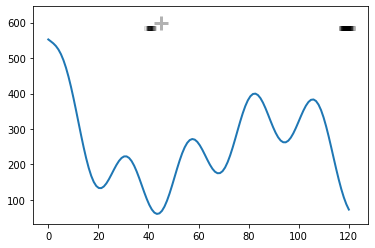

final position error, variance:
	 59.62544488368303 973.1143884629762


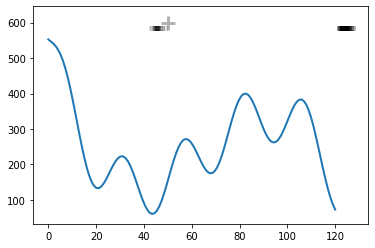

final position error, variance:
	 -3.7648507491796863 1.2512843124630872


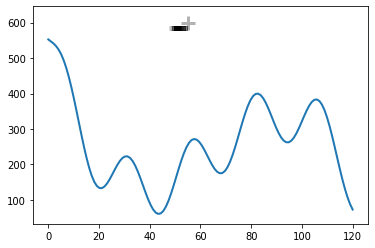

final position error, variance:
	 -3.788574583072851 2.415130080040959


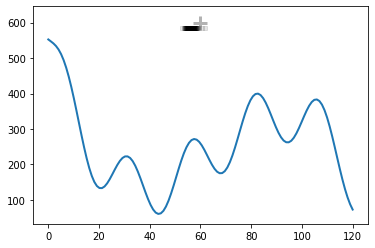

final position error, variance:
	 -3.353156418178699 3.2420731145043162


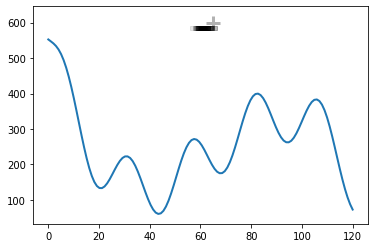

final position error, variance:
	 -3.2036936183061044 3.8643871218966637


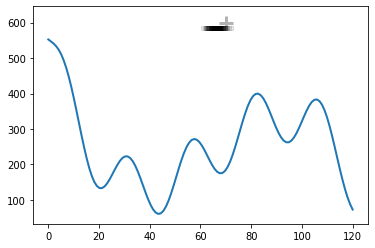

final position error, variance:
	 -4.1485102044750874 2.697181786316509


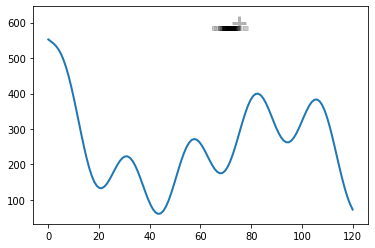

final position error, variance:
	 -3.163635389101472 2.0531428675352528


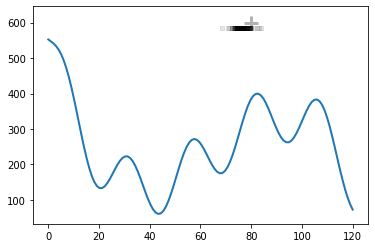

final position error, variance:
	 -3.6672866116617087 4.701041893425927


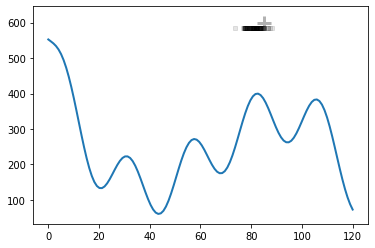

final position error, variance:
	 -3.2958807176893856 4.3563438842033895


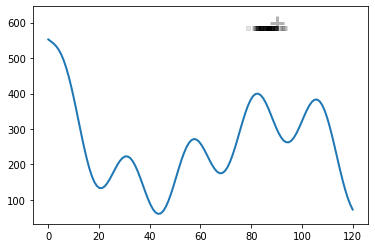

In [22]:
import numpy as np
from filterpy.monte_carlo import systematic_resample
from numpy.linalg import norm
from numpy.random import randn
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline

class HelicopterParticle:
    """
    reference from https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/12-Particle-Filters.ipynb

    1D map which was generated by polynomial function
    axis: the number of axis dots (discrete)
    low: the shortest distance to the ground
    high: the highest distance to the ground

    the helicopter
    suppose that it keeps the same elevation
    start: initialization of location
    velocity: the speed of moving 

    particles
    num: the number of generating particles
    """
    def __init__(self, low, high, start, velocity, num):
        self.low = low
        self.high = high
        self.loc = start
        self.velocity = velocity
        self.particles = np.random.uniform(low=0, high=high, size=num) # uniform
        self.weights = np.ones(num) * 1/num
        self.num = num

    # the distance to the ground that the sensor gets
    def distance(self, x):
        p1 = -0.002428
        p2 = 0.4773
        p3 = -25.65
        p4 = 552.4
        dist = p1*np.power(x, 3) + p2*np.power(x, 2) + p3*x + p4 + 80*np.sin(x/4)
        return dist

    def move(self, dt=1.):
        """
        the movement of particles and helicopter
        """
        self.loc += self.velocity*dt
        num = len(self.particles)
        self.particles += self.velocity*dt + randn(num)

    def update(self, z, R):
        # distance = np.linalg.norm(self.distance(self.particles), axis=1)
        distance = self.distance(self.particles)
        self.weights *= scipy.stats.norm(distance, R).pdf(z)
        self.weights += 1.e-300      # avoid round-off to zero
        self.weights /= sum(self.weights) # normalize

    def estimate(self):
        """
        returns mean and variance of the weighted particles
        """
        mean = np.average(self.particles, weights=self.weights, axis=0)
        var  = np.average((self.particles - mean)**2, weights=self.weights, axis=0)
        return mean, var

    def resample_from_index(self, indexes):
        self.particles[:] = self.particles[indexes]
        self.weights.resize(len(self.particles))
        self.weights.fill (1.0 / len(self.weights))

    def neff(self):
        return 1. / np.sum(np.square(self.weights))

    def run_pf1(self, iters=18, sensor_std_err=50.):
        N = self.num

        plt.figure()

        # plot the map: simulate the mountains
        x = np.linspace(self.low, self.high, 120)
        y = self.distance(x)

        plt.plot(x, y, linewidth=2.0)
        plt.scatter(self.particles, np.ones(N)*600, color='k', marker=',', s=1)
        p1 = plt.scatter(self.loc, 600, marker='+', color='k', s=180, lw=3)
        plt.show()
        
        for i in range(iters):

            # distance from helicopter to ground
            # zs = (norm(self.distance(self.loc), axis=1) + (randn(1) * sensor_std_err))
            zs = self.distance(self.loc) + (randn(1) * sensor_std_err)

            # movement
            self.move()

            # incorporate measurements
            self.update(z=zs, R=sensor_std_err)

            # resample if too few effective particles
            if self.neff() < N/2:
                indexes = systematic_resample(self.weights)
                self.resample_from_index(indexes)
                assert np.allclose(self.weights, 1/N)
            mu, var = self.estimate()

            # plot the map
            plt.scatter(self.particles, np.ones(N)*585, color='k', marker=',', s=10,alpha=0.1)
            plt.plot(x, y, linewidth=2.0, label="Distance")
            p2 = plt.scatter(self.loc, 600, marker='+', color='k', s=180, lw=3, alpha=0.3)
            #p3 = plt.scatter(mu, 600, marker='s', color='r', alpha=0.3)

            #plt.legend([p2, p3], ['Actual(Helicopter)', 'PF'], loc=4, numpoints=1)
            print('final position error, variance:\n\t', mu - self.loc, var)
            plt.show()


helicopter = HelicopterParticle(low=0, high=120, start=0, velocity=5, num=100)
helicopter.run_pf1()